# Key papers

**TOPICS OF INTEREST** - from the meeting in January

* inflammation aging chronic (2004) - 13k papers
* genome editing / manipulation, CRISPR - 13k papers
* induced stem cells - 73k papers - 3h for calculating co-citations
* single-cell sequencing (2012) - 3k papers
* ATAC-seq (2015) - 276 papers
* immunomodulation cancer - 71k papers
* Telomere Theories of Aging - ??
* mTOR pathway - 14255
* autophagy - ??
* Calorie restriction - 3933

Complement Factor H + Age-Related Mascular Degeneration - investigate

**Functions**:

1. Subtopic Analysis based on co-citation graph clustering
2. Top Cited Papers detection (overall and for certain year)
3. Citation Dynamics for a certain article

## Search Terms

In [356]:
SEARCH_TERMS = ['dna', 'methylation', 'clock']

In [480]:
import logging
import re
import gc
import ipywidgets as widgets
import math
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, LabelSet, OpenURL, CustomJS
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.core.properties import value
from bokeh.colors import Color, RGB
from bokeh.io import show
from bokeh.models import Plot, Range1d, MultiLine, Circle
# Tools used: hover,pan,tap,wheel_zoom,box_zoom,reset,save
from bokeh.models import HoverTool, PanTool, TapTool, WheelZoomTool, BoxZoomTool, ResetTool, SaveTool
from bokeh.models.graphs import from_networkx

from time import sleep

from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import community
from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
output_notebook()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

2019-05-12 17:10:22,375 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [358]:
class KeyPaperAnalyzer:       
    def __init__(self):
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def load_publications(self):
        logging.info('Loading publication data')
        
        values = ', '.join(['({})'.format(i) for i in sorted(self.pmids)])
        query = re.sub('\$VALUES\$', values, '''
        DROP TABLE IF EXISTS TEMP_PMIDS;
        WITH vals(pmid) AS (VALUES $VALUES$)
        SELECT pmid INTO temporary table TEMP_PMIDS FROM vals;        
        DROP INDEX IF EXISTS temp_pmids_unique_index;
        CREATE UNIQUE INDEX temp_pmids_unique_index ON TEMP_PMIDS USING btree (pmid);

        SELECT P.pmid, P.title, P.year
        FROM Publications P
        JOIN TEMP_PMIDS AS T ON (P.pmid = T.pmid);
        ''')
        logging.info('Creating pmids table for request with index.')
        with self.conn:
            self.cursor.execute(query)
            
        pub_data = []
        for row in self.cursor:
            pub_data.append(list(row))
        self.pub_df = pd.DataFrame(pub_data, columns=['pmid', 'title', 'year'])
        logging.info(f'Found {len(self.pub_df)} publications in the local database')
            
    def load_cocitations(self):
        logging.info('Calculating co-citations for selected articles')
        # Use unfolding to pairs on the client side instead of DataBase        
        query = '''
        with Z as (select pmid_citing, pmid_cited
            from citations
            -- Hack to make Postgres use index!
            where pmid_cited between %s and %s
            and pmid_cited in (select pmid from TEMP_PMIDS)),
        X as (select pmid_citing, array_agg(pmid_cited) as cited_list
            from Z
            group by pmid_citing
            having count(*) >= 2)
        select X.pmid_citing, P.year, X.cited_list from
            X join publications P
            on pmid_citing = P.pmid;
        '''

        with self.conn:
            self.cursor.execute(query, (min(self.pmids), max(self.pmids), ))
            
        cocit_data = []
        lines = 0
        for row in self.cursor:
            lines += 1
            citing, year, cited = row
            for i in range(len(cited)):
                for j in range(i + 1, len(cited)):
                    cocit_data.append((citing, cited[i], cited[j], year))
        self.cocit_df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])
        logging.info(f'Loaded {lines} lines of citing info')
        logging.info(f'Found {len(self.cocit_df)} co-cited pairs of articles')

        logging.info(f'Aggregating co-citations')
        self.cocit_grouped_df = self.cocit_df.groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                          columns=['year'], values=['citing']).reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.replace(np.nan, 0)
        self.cocit_grouped_df['total'] = self.cocit_grouped_df.iloc[:, 2:].sum(axis=1)
        self.cocit_grouped_df = self.cocit_grouped_df.sort_values(by='total', ascending=False)
        logging.info('Filtering top 10000 or 80% of all the co-citations')
        self.cocit_grouped_df = self.cocit_grouped_df.iloc[:min(10000, round(0.8 * len(self.cocit_grouped_df))), :]
        logging.info(f'Building co-citations graph')
        ids_available = set(pd.merge(self.pub_df, self.cit_df, on='pmid')['pmid'])
        self.CG = nx.Graph()
        # NOTE: we use nodes id as String to avoid problems str keys in jsonify during graph visualization
        for el in analyzer.cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
            start, end, weight = el
            if start in ids_available and end in ids_available:
                self.CG.add_edge(str(start), str(end), weight=weight)
        logging.info(f'Co-citations graph nodes {len(self.CG.nodes())} edges {len(self.CG.edges())}')
            
    def load_citation_stats(self):
        logging.info('Started loading citation stats')

        query = '''
        with Z as (select pmid_citing, pmid_cited
        from citations
            -- Hack to make Postgres use index!
            where pmid_cited between %s and %s
            and pmid_cited in (select pmid from TEMP_PMIDS))
        select Z.pmid_cited, P.year, COUNT(1) from
        Z join publications P
        on Z.pmid_citing = P.pmid
            -- Hack to make Postgres use index!
            where Z.pmid_cited between %s and %s
            and P.year > 0
        GROUP BY Z.pmid_cited, P.year;
        '''

        with self.conn:
            self.cursor.execute(query, 
                                (min(self.pmids), max(self.pmids), min(self.pmids), max(self.pmids),))
        logging.info('Done loading citation stats')

        pub_data = []
        for row in analyzer.cursor:
            pub_data.append(list(row))
        self.cit_df = pd.DataFrame(pub_data, columns=['pmid', 'year', 'count'])
        
        self.cit_df = self.cit_df.pivot(index='pmid', columns='year', values='count').reset_index().replace(np.nan, 0)
        self.cit_df['total'] = self.cit_df.iloc[:, 1:].sum(axis = 1)
        self.cit_df = self.cit_df.sort_values(by='total', ascending=False)
        
        logging.info(f"Loaded citation stats for {len(self.cit_df)} of {len(self.pmids)} articles. " +
                    "Others may either have zero citations or be absent in the local database.")        
            
    def plot_total_citations(self):
        plt.figure(figsize=(10, 5))
        ax = self.cit_df['total'].plot.bar()
        ax.set_xticklabels([])
        ax.set_xlabel('Articles')
        ax.set_ylabel('Number of citations')
    
    def search(self, *terms):
        print('TODO: handle queries which return more than 1000000 items')
        print('TODO: use local database instead of PubMed API')
        self.terms = [t.lower() for t in terms]
        query=' '.join(terms)
        handle = Entrez.esearch(db='pubmed', retmax='1000000', retmode='xml', term=query)
        self.pmids = [int(pmid) for pmid in Entrez.read(handle)['IdList']]
        logging.info(f'Found {len(self.pmids)} articles about {terms}')       
        
    def top_cited_papers(self, threshold=0.05):
        ids = self.cit_df.iloc[:round(len(self.cit_df) * threshold), 0].values
        counts = self.cit_df.iloc[:round(len(self.cit_df) * threshold), -1].values
        urls = [PUBMED_ARTICLE_BASE_URL + str(i) for i in ids]
        return zip(ids, urls, counts)

In [359]:
def build_data_source(df):
    ARTICLE_LAYOUT_WIDTH = 900
    ARTICLE_LAYOUT_HEIGHT = 300

    # Sort papers from the same year with total number of citations as key, use rank as y-pos
    ranks = df.groupby('year')['total'].rank(ascending=False, method='first')
    
    # Calculate max size of circles to avoid overlapping along x-axis
    max_radius_screen_units = ARTICLE_LAYOUT_WIDTH / (max_year - min_year + 1)
    size_scaling_coefficient = max_radius_screen_units / np.log(df['total']).max()
    
    d = ColumnDataSource(data=dict(pmid=df['pmid'], title=df['title'], year=df['year'], total=df['total'], 
                                   size=np.log(df['total']) * size_scaling_coefficient, pos=ranks))
    return d

In [487]:
TOOLS = "hover,pan,tap,wheel_zoom,box_zoom,reset,save"

def serve_scatter_article_layout(source, title, year_range=None, color='blue'):
    callback = CustomJS(args=dict(source=source, base=PUBMED_ARTICLE_BASE_URL), code="""
        var data = source.data, selected = source.selected.indices;
        if (selected.length == 1) {
            // only consider case where one glyph is selected by user
            selected_id = data['pmid'][selected[0]]
            for (var i = 0; i < data['pmid'].length; ++i){
                if(data['pmid'][i] == selected_id){
                    window.open(base + data['pmid'][i], '_blank');
                }
            }
        }
    """)

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=400, x_range=year_range, title=title)
    p.xaxis.axis_label = 'Year'
    p.yaxis.axis_label = 'Amount of articles'
    p.y_range.start = 0
    p.hover.tooltips = [
        ("PMID", '@pmid'),
        ("Title", '@title'),
        ("Year", '@year'),
        ("Cited by", '@total paper(s) total')
    ]
    p.js_on_event('tap', callback)

    p.circle(x='year', y='pos', fill_alpha=0.5, source=source, size='size', line_color=color, fill_color=color)
    
    return p

def serve_citation_dynamics_layout(highlight_papers):
    print('TODO: add line showing year of publication')
    
    def update(b):
        pmid = dropdown.value
        data = df_all[df_all['pmid'] == pmid]
        
        x = data.columns[3:-2].values.astype(int)
        y = data[x].values[0]
        
#         max_cit = np.max(data[x], axis=1).values[0]
#         line_x = [data['year'].values[0]] * 2
#         line_y = [-10, 1.5 * max_cit]
        
        bar.data_source.data = {'x': x, 'y': y}
#         line.data_source.data = {'x': line_x, 'y': line_y}
        
        push_notebook(handle=h)

    title = "Number of Citations per Year"
    d = ColumnDataSource(data=dict(x=[], y=[]))
    l = ColumnDataSource(data=dict(x=[], y=[]))
    
    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, 
               plot_height = 300, title=title)
    bar = p.vbar(x='x', width=0.8, top='y', source=d, color='#A6CEE3', line_width=3)
#     line = p.line(x='x', y='y', source=l, color='#FF6666', line_width=3, legend='Year of publication')
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Number of citations"
    p.hover.tooltips = [
        ("Year", "@x"),
        ("Cited by", "@y paper(s) in @x"),
    ]
#     p.legend.orientation = "horizontal"
#     p.legend.location = "top_left"
    
    dropdown = widgets.Dropdown(
        options=list(highlight_papers),
        description='PMID:',
        disabled=False
    )

    button = widgets.Button(
        description='Show',
        disabled=False,
        button_style='info',
        tooltip='Show'
    )
    button.on_click(update)

    panel = widgets.HBox([dropdown, button])

    display(panel)
    h = show(p, notebook_handle=True)
    
    return p, h, panel

In [361]:
analyzer = KeyPaperAnalyzer()
analyzer.search(*SEARCH_TERMS)
analyzer.load_publications()
# analyzer.pub_df.head()

TODO: handle queries which return more than 1000000 items
TODO: use local database instead of PubMed API


2019-05-12 03:31:21,124 INFO: Found 297 articles about ('dna', 'methylation', 'clock')
2019-05-12 03:31:21,128 INFO: Loading publication data
2019-05-12 03:31:21,132 INFO: Creating pmids table for request with index.
2019-05-12 03:31:35,481 INFO: Found 223 publications in the local database


In [362]:
analyzer.load_citation_stats()
# analyzer.cit_df.head()

2019-05-12 03:31:35,507 INFO: Started loading citation stats
2019-05-12 03:35:52,550 INFO: Done loading citation stats
2019-05-12 03:35:52,651 INFO: Loaded citation stats for 174 of 297 articles. Others may either have zero citations or be absent in the local database.


In [363]:
analyzer.load_cocitations()
# analyzer.cocit_df.head()

2019-05-12 03:35:52,665 INFO: Calculating co-citations for selected articles
2019-05-12 03:35:54,777 INFO: Loaded 418 lines of citing info
2019-05-12 03:35:54,778 INFO: Found 4876 co-cited pairs of articles
2019-05-12 03:35:54,780 INFO: Aggregating co-citations
2019-05-12 03:35:54,911 INFO: Filtering top 10000 or 80% of all the co-citations
2019-05-12 03:35:54,912 INFO: Building co-citations graph
2019-05-12 03:35:55,145 INFO: Co-citations graph nodes 128 edges 870


## Subtopics a.k.a. Clusters in the Co-citation Graph

In [364]:
df_pub_cit = pd.merge(analyzer.pub_df, analyzer.cit_df, on='pmid')
# df_pub_cit.head()

In [365]:
logging.info(f'Louvain community clustering of co-citation graph')
p = community.best_partition(analyzer.CG)
components = set(p.values())
logging.info(f'Found {len(components)} components')
logging.info(f'Graph modularity: {community.modularity(p, analyzer.CG):.3f}')

2019-05-12 03:35:56,981 INFO: Louvain community clustering of co-citation graph
2019-05-12 03:35:57,138 INFO: Found 5 components
2019-05-12 03:35:57,148 INFO: Graph modularity: 0.262


In [366]:
# This will limit total number of components
GRANULARITY = 0.01
logging.info(f'Merging components smaller than {GRANULARITY} to "Other" component')
threshold = int(GRANULARITY * len(p))
comp_sizes = {com: sum([p[node] == com for node in p.keys()]) for com in components}
comp_to_merge = {com: comp_sizes[com] <= threshold for com in components}
components_merged = sum(comp_to_merge.values()) > 0
if components_merged:
    logging.info(f'Reassigning components, component 0 is "Other"')
    pm = {}
    newcomps = {}
    ci = 1 # Other component is 0.
    for k, v in p.items():
        if comp_sizes[v] <= threshold:
            pm[k] = 0 # Other
            continue
        if v not in newcomps:
            newcomps[v] = ci
            ci += 1
        pm[k] = newcomps[v]
    logging.info(f'Processed {len(set(pm.values()))} components')
else:
    pm = p
components = set(pm.values())    
pmcomp_sizes = {com: sum([pm[node] == com for node in pm.keys()]) for com in components}
logging.info('\n'.join([f'{k}: {v} ({int(100 * v / len(pm))}%)' for k,v in pmcomp_sizes.items()]))

2019-05-12 03:35:57,705 INFO: Merging components smaller than 0.01 to "Other" component
2019-05-12 03:35:57,707 INFO: 0: 25 (19%)
1: 39 (30%)
2: 50 (39%)
3: 12 (9%)
4: 2 (1%)


In [367]:
pm_ints = {int(k): v for k,v in pm.items()}
df_comp = pd.Series(pm_ints).reset_index().rename(columns={'index': 'pmid', 0: 'comp'})
# Important: not all the nodes can present in graph, since can be no edges for them!
df_all = pd.merge(df_pub_cit, df_comp, on='pmid')
# df_all.head()

In [368]:
from bokeh.models import GraphRenderer, StaticLayoutProvider

logging.info('Visualizing components with Chord diagram')

G = nx.Graph()
# Using merge left keeps order
gdf = pd.merge(pd.Series(analyzer.CG.nodes()).reset_index().rename(columns={0: 'pmid'}).astype(int), 
               df_all[['pmid', 'title', 'year', 'total', 'comp']], how='left').sort_values(by='total', ascending=False)

for c in range(len(components)):
    for n in gdf[gdf['comp'] == c]['pmid']:
        # NOTE: we use nodes id as String to avoid problems str keys in jsonify during graph visualization
        G.add_node(str(n))

edge_starts = []
edge_ends = []
for start, end in analyzer.CG.edges():
    edge_starts.append(start)
    edge_ends.append(end)

cmap = plt.cm.get_cmap('jet', len(set(pm.values())))
comp_palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(set(pm.values())))]

# Show with Bokeh
plot = Plot(plot_width=800, plot_height=800, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = 'Co-citations graph'

graph = GraphRenderer()
graph.node_renderer.data_source.add(list(G.nodes), 'index')
graph.edge_renderer.data_source.data = dict(start=edge_starts, end=edge_ends)

# Start of layout code
circ = [i*2*math.pi/len(G.nodes()) for i in range(len(G.nodes()))]
x = [math.cos(i) for i in circ]
y = [math.sin(i) for i in circ]
graph_layout = dict(zip(list(G.nodes()), zip(x, y)))
graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

# Draw quadratic bezier paths
def bezier(start, end, steps=10, c=1.5):
    return [(1-s)**c*start + s**c*end for s in np.linspace(0, 1, steps)]

xs, ys = [], []
edge_colors = []
edge_alphas = []
for edge_start, edge_end in zip(edge_starts, edge_ends):
    sx, sy = graph_layout[edge_start]
    ex, ey = graph_layout[edge_end]
    xs.append(bezier(sx, ex))
    ys.append(bezier(sy, ey))
    if pm[edge_start] == pm[edge_end]:
        edge_colors.append(comp_palette[pm[edge_start]])
        edge_alphas.append(0.5)
    else:
        edge_colors.append('grey')
        edge_alphas.append(0.1)

        
# Paths for edges
graph.edge_renderer.data_source.data['xs'] = xs
graph.edge_renderer.data_source.data['ys'] = ys

# Style for edges
graph.edge_renderer.data_source.data['edge_colors'] = edge_colors
graph.edge_renderer.data_source.data['edge_alphas'] = edge_alphas

# TODO: use ColumnDatasource 
# Nodes data for rendering
graph.node_renderer.data_source.data['pmid'] = list(G.nodes())
graph.node_renderer.data_source.data['colors'] = [comp_palette[pm[n]] for n in G.nodes()]
graph.node_renderer.data_source.data['title'] = gdf['title']
graph.node_renderer.data_source.data['year'] = gdf['year']
graph.node_renderer.data_source.data['total'] = gdf['total']
log_total = np.log(gdf['total'])
graph.node_renderer.data_source.data['size'] = (log_total / np.max(log_total)) * 5 + 5
graph.node_renderer.data_source.data['topic'] =\
    [ f'#{pm[n]}{" OTHER" if pm[n] == 0 and components_merged else ""}' for n in G.nodes()]

# node rendering
graph.node_renderer.glyph = Circle(size='size', line_color='colors', fill_color='colors', 
                                   line_alpha=0.5, fill_alpha=0.5)
# edge rendering
graph.edge_renderer.glyph = MultiLine(line_color='edge_colors', line_alpha='edge_alphas', line_width=1)

# add tools to the plot
# hover,pan,tap,wheel_zoom,box_zoom,reset,save
plot.add_tools(HoverTool(tooltips=[
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@year'),
    ("Cited by", '@total paper(s) total'),
    ("Subtopic", '@topic')]), 
               PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool(), SaveTool())

plot.renderers.append(graph)
     
show(plot)

2019-05-12 03:35:59,540 INFO: Visualizing components with Chord diagram


In [407]:
years = df_all.columns.values[3:-2].astype(int)
min_year, max_year = np.min(years), np.max(years)

In [408]:
print(min_year, max_year)

1985 2019


In [371]:
logging.info('Summary component detailed info visualization')

n_comps = df_all['comp'].nunique()
cmap = plt.cm.get_cmap('jet', n_comps)
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(n_comps)]

components = [str(i) for i in range(n_comps)]
years = list(range(min_year, max_year))
data = {'years': years}
for c in range(n_comps):
    data[str(c)] = [len(df_all[np.logical_and(df_all['comp'] == c, df_all['year'] == y)]) \
                    for y in range(min_year, max_year)]

p = figure(x_range=[min_year, max_year], plot_width=960, plot_height=300, title="Components by Year",
           toolbar_location=None, tools="hover", tooltips="#$name: @$name")

p.vbar_stack(components, x='years', width=0.9, color=palette, source=data, alpha=0.5,
             legend=[value(c) for c in components])

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

2019-05-12 03:36:03,299 INFO: Summary component detailed info visualization


In [372]:
from collections import Counter
from nltk.stem import WordNetLemmatizer 

def get_ngrams(string):
    "1/2/3-gramms computation for string"
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = nltk.word_tokenize(re.sub('[^a-zA-Z0-9\- ]*', '', string.lower()))
    stop_words = set(stopwords.words('english')) 
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos) and word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(n) for n in nouns]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

def get_most_common_ngrams(titles, number=50):
    ngrams = []
    for title in titles:
        ngrams.extend(get_ngrams(title))
    most_common = {}
    for ngram, cnt in Counter(ngrams).most_common(number):
        most_common[ngram] = cnt / len(ngrams)
    return most_common

In [405]:
# Reorder subtopics by either size or number of citations descending
KEY = 'citations' # 'size' or 'citations'

start = int(components_merged) # Sort from component #1 if merged, Other should be the lowest priority
if KEY == 'size':
    order = df_all.groupby('comp')['pmid'].count().sort_values(ascending=False).index.values
elif KEY == 'citations':
    order = df_all.groupby('comp')['total'].sum().sort_values(ascending=False).index.values
df_all['comp'] = df_all['comp'].map(dict(enumerate(order)))

In [409]:
logging.info('Per component detailed info visualization')
n_comps = df_all['comp'].nunique()
ds = [None] * n_comps
layouts = [None] * n_comps
most_common = [None] * n_comps
cmap = plt.cm.get_cmap('jet', n_comps)

logging.info('Compute most common n-gramms')
for c in range(n_comps):
    most_common[c] = dict(get_most_common_ngrams(df_all[df_all['comp'] == c]['title'].values))

logging.info('Compute Augmented Term Frequency - Inverse Document Frequency')
# The tf–idf is the product of two statistics, term frequency and inverse document frequency.
# This provides greater weight to values that occur in fewer documents.
idfs = {}    
for c in range(n_comps):
    max_cnt = max(most_common[c].values())
    idfs[c] = {k: (0.5 + 0.5 * v / max_cnt) *  # augmented frequency to avoid document length bias
               np.log(n_comps / sum([k in mcoc for mcoc in most_common])) for k,v in most_common[c].items()}

for c in range(n_comps):
    kwd = ', '.join([f'{k} ({most_common[c][k]:.2f})' \
                     for k,_v in list(sorted(idfs[c].items(), key=lambda kv: kv[1], reverse=True))[:5]])
    title = f'Subtopic #{c}{" OTHER" if c == 0 and components_merged else ""}: {kwd}'
    
    ds[c] = build_data_source(df_all[df_all['comp'] == c])
    layouts[c] = serve_scatter_article_layout(ds[c], title, year_range=[min_year, max_year], 
                                              color=RGB(*[round(ch*255) for ch in cmap(c)[:3]]))
    show(layouts[c])

2019-05-12 15:44:15,200 INFO: Per component detailed info visualization
2019-05-12 15:44:15,205 INFO: Compute most common n-gramms
2019-05-12 15:44:19,063 INFO: Compute Augmented Term Frequency - Inverse Document Frequency


In [410]:
logging.info('Subtopic Summary')
for c in range(n_comps):
    kwd = ', '.join([f'{k} ({most_common[c][k]:.2f})' \
                     for k,_v in list(sorted(idfs[c].items(), key=lambda kv: kv[1], reverse=True))[:5]])
    print(f'Subtopic #{c}{" OTHER" if c == 0 and components_merged else ""}: {kwd}')

2019-05-12 15:44:26,074 INFO: Subtopic Summary


Subtopic #0: change (0.01), infection (0.01), patient (0.01), cerebellum (0.01), age (0.04)
Subtopic #1: expression (0.01), arabidopsis (0.01), clock gene (0.01), rhythm (0.01), gene expression (0.01)
Subtopic #2: acceleration (0.01), clock analysis (0.01), risk (0.01), rate (0.01), measure (0.00)
Subtopic #3: cytosine (0.04), fate (0.04), cpg (0.04), dinucleotides (0.04), vertebrate (0.04)
Subtopic #4: stem (0.04), stem cell (0.03), division (0.02), replication (0.02), division cell (0.01)


## Top Cited Papers Overall

In [375]:
df_all = df_all.sort_values(by='total', ascending=False)

In [376]:
THRESHOLD = 0.1 # 10 %
MAX_PAPERS = 20

In [424]:
print('TODO: color me by components colors')
papers_to_show = min(MAX_PAPERS, round(len(analyzer.cit_df) * THRESHOLD))

ds_top = build_data_source(df_all.iloc[:papers_to_show, :])
layout_top = serve_scatter_article_layout(ds_top, 'Top cited papers', year_range=[min_year, max_year])
show(layout_top)

logging.info('Top cited papers in total')
df_all.sort_values('total', axis=0, ascending = False)[['pmid', 'title', 'year', 'total']].head(papers_to_show)

top_cited_papers = set(df_all.loc[:papers_to_show, 'pmid'].astype(int).values)

TODO: color me by components colors


2019-05-12 15:55:24,365 INFO: Top cited papers in total


## Top Cited Papers for Each Year

In [425]:
max_gain_data = []
cols = df_all.columns[3:-2]
for i in range(len(cols)):
    max_gain = df_all[cols[i]].astype(int).max()
    if max_gain > 0:
        sel = df_all[df_all[cols[i]] == max_gain]
        max_gain_data.append([cols[i], sel['pmid'].values[0], sel['title'].values[0], 
                              sel['year'].values[0], max_gain])
        
max_gain_df = pd.DataFrame(max_gain_data, columns=['year', 'pmid', 'title', 'paper_year', 'count'])

ds_max = ColumnDataSource(data=dict(year=max_gain_df['year'], pmid=max_gain_df['pmid'].astype(str),
                                    title=max_gain_df['title'], paper_year=max_gain_df['paper_year'],
                                    count=max_gain_df['count']))
factors=max_gain_df['pmid'].astype(str).unique()
cmap = plt.cm.get_cmap('jet', len(factors))
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(factors))]
colors = factor_cmap('pmid', palette=palette, factors=factors)

year_range = [min_year, max_year]
p = figure(tools=TOOLS, toolbar_location="above", 
           plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@paper_year'),
    ("Cited by", '@count papers in @year')
]

p.vbar(x='year', width=0.8, top='count', fill_alpha=0.5, source=ds_max, fill_color=colors, line_color=colors)
logging.info('Different colors encode different papers')
show(p)

max_gain_papers = set(max_gain_df['pmid'].astype(int).values)

2019-05-12 15:55:25,191 INFO: Different colors encode different papers


## Top by Relative Gain for Each Year

In [380]:
current_sum = pd.Series(np.zeros(len(df_all),))
cols = df_all.columns[3:-2]
df_rel = df_all.loc[:, ['pmid', 'title', 'year']]
for col in cols:
    df_rel[col] = df_all[col] / (current_sum + (current_sum == 0))
    current_sum += df_all[col]

In [426]:
max_rel_gain_data = []
cols = df_all.columns[3:-2]
for col in cols:
    max_rel_gain = df_rel[col].max()
    if max_rel_gain > 1e-6:
        sel = df_rel[df_rel[col] == max_rel_gain]
        max_rel_gain_data.append([col, sel['pmid'].values[0], sel['title'].values[0], 
                                  sel['year'].values[0], max_rel_gain])
                          
max_rel_gain_df = pd.DataFrame(max_rel_gain_data, columns=['year', 'pmid', 'title', 'paper_year', 'rel_gain'])

ds_max = ColumnDataSource(data=dict(year=max_rel_gain_df['year'], pmid=max_rel_gain_df['pmid'].astype(str),
                                    title=max_rel_gain_df['title'], paper_year=max_rel_gain_df['paper_year'],
                                    rel_gain=max_rel_gain_df['rel_gain']))
factors=max_rel_gain_df['pmid'].astype(str).unique()
cmap = plt.cm.get_cmap('jet', len(factors))
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(factors))]
colors = factor_cmap('pmid', palette=palette, factors=factors)

year_range = [min_year, max_year]
p = figure(tools=TOOLS, toolbar_location="above", 
           plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Relative Gain of Citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@paper_year'),
    ("Relative Gain", '@rel_gain in @year')
]

p.vbar(x='year', width=0.8, top='rel_gain', fill_alpha=0.5, source=ds_max, fill_color=colors, line_color=colors)
logging.info('Top papers in relative gain for each year')
logging.info('Relative gain (year) = Citation Gain (year) / Citations before year')
logging.info('Different colors encode different papers')
show(p)

max_rel_gain_papers = set(max_rel_gain_df['pmid'].astype(int).values)

2019-05-12 15:55:28,434 INFO: Top papers in relative gain for each year
2019-05-12 15:55:28,436 INFO: Relative gain (year) = Citation Gain (year) / Citations before year
2019-05-12 15:55:28,438 INFO: Different colors encode different papers


## Citation per Year Dynamics

In [488]:
highlight_papers = top_cited_papers.union(max_gain_papers, max_rel_gain_papers)

logging.info('Choose ID to get detailed citations timeline for top cited / max gain or relative gain papers')
p, h, panel = serve_citation_dynamics_layout(sorted(highlight_papers))

2019-05-12 17:19:38,486 INFO: Choose ID to get detailed citations timeline for top cited / max gain or relative gain papers


TODO: add line showing year of publication


HBox(children=(Dropdown(description='PMID:', options=(1722018, 2777259, 15790588, 15860628, 15975143, 16717091, 17029560, 18483325, 19861541, 21139085, 21811413, 22080730, 22438023, 23003921, 23217262, 24138928, 24531307, 25313081, 25617346, 25678027, 25913071, 25969563, 26000617, 26594032, 26655927, 26673150, 26678252, 26684672, 27274774, 27511193, 27690265, 28089957), value=1722018), Button(button_style='info', description='Show', style=ButtonStyle(), tooltip='Show')))

## Component Evolution

In [383]:
cocit_df = analyzer.cocit_df.copy()
min_year = cocit_df['year'].min().astype(int)
max_year = cocit_df['year'].max().astype(int)
print(f'Cocitation year range: {min_year} - {max_year}')

Cocitation year range: 2006 - 2018


In [384]:
YEAR_STEP = 2

evolution_series = []
year_range = range(max_year, min_year-1, -YEAR_STEP)
print('Filtering top 10000 or 80% of all the co-citations')
for year in range(max_year, min_year-1, -YEAR_STEP):   
    cocit_grouped_df = cocit_df[cocit_df['year'] <= year].groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
    cocit_grouped_df = cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                    columns=['year'], values=['citing']).reset_index()
    cocit_grouped_df = cocit_grouped_df.replace(np.nan, 0)
    cocit_grouped_df['total'] = cocit_grouped_df.iloc[:, 2:].sum(axis=1)
    cocit_grouped_df = cocit_grouped_df.sort_values(by='total', ascending=False)
    cocit_grouped_df = cocit_grouped_df.iloc[:min(10000, round(0.8 * len(cocit_grouped_df))), :]
    
    CG = nx.Graph()
    # NOTE: we use nodes id as String to avoid problems str keys in jsonify during graph visualization
    for el in cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
        CG.add_edge(str(el[0]), str(el[1]), weight=el[2])
    print(f'{year} - {len(CG.nodes)} nodes, {len(CG.edges)} edges') 
    
    p = {int(vertex): int(comp) for vertex, comp in community.best_partition(CG).items()}
    evolution_series.append(pd.Series(p))

Filtering top 10000 or 80% of all the co-citations
2018 - 131 nodes, 905 edges
2016 - 85 nodes, 426 edges
2014 - 48 nodes, 180 edges
2012 - 21 nodes, 37 edges
2010 - 15 nodes, 23 edges
2008 - 11 nodes, 10 edges
2006 - 3 nodes, 2 edges


In [385]:
SHIFT = True # use random shift to see trace of separate articles
FILLNA = True # NaN values sometimes cause KeyError while plotting, but sometimes not (?!)

evolution_df = pd.concat(evolution_series, axis=1).rename(columns=dict(enumerate(year_range)))
evolution_df['current'] = evolution_df[max_year]
evolution_df = evolution_df[list(reversed(list(evolution_df.columns)))]

if SHIFT:
    shift = np.random.uniform(0.25, 0.75, size=(len(evolution_df),))
    for year in year_range:
        evolution_df[year] += shift
        
if FILLNA:
    evolution_df = evolution_df.fillna(-1.0)

evolution_df.head()

,current,2006,2008,2010,2012,2014,2016,2018
1722018,3.0,0.60395,0.603950,0.603950,1.603950,2.603950,2.603950,3.603950
2777259,4.0,-1.00000,1.390072,-1.000000,-1.000000,6.390072,4.390072,4.390072
14577056,3.0,-1.00000,-1.000000,-1.000000,-1.000000,2.560927,2.560927,3.560927
15790588,2.0,-1.00000,2.749298,2.749298,2.749298,1.749298,1.749298,2.749298
15860628,2.0,-1.00000,2.363921,1.363921,0.363921,0.363921,1.363921,2.363921


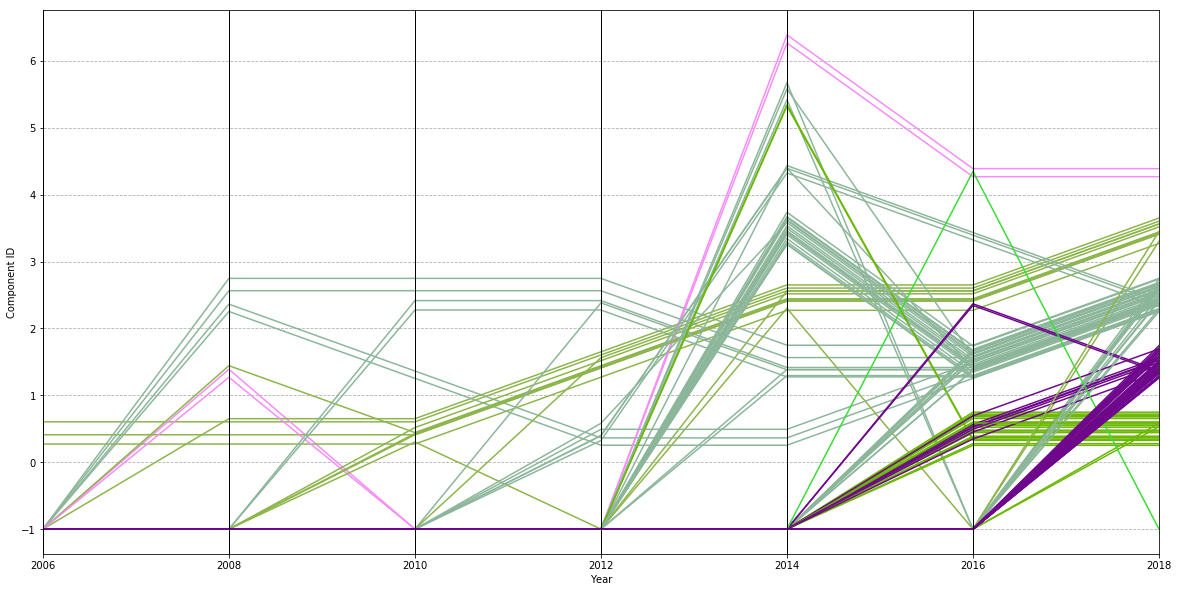

In [386]:
plt.rcParams['figure.figsize'] = 20, 10
pd.plotting.parallel_coordinates(evolution_df, 'current', sort_labels=True)
plt.xlabel('Year')
plt.ylabel('Component ID')
plt.grid(b=True, which='both', linestyle='--')
plt.legend().set_visible(False)